# Non-negative Matrix Factorization applied to Topic Extraction

<img src="https://miro.medium.com/max/1100/1*ru1Ek9T3FjkehDkD8FZoHQ.webp" style="max-height:500px">

NMF alongside with Latent-Dirichlet-Allocation and Neural Networks is a popular choice for topic extraction, where one tries to find which document belongs to which category and extract a collection of the most meaningful words of each associated topic.

We will use a popular dataset on posts from 20 different newsgroups on specific topics and try to extract these from the randomized collection of all posts using NMF. To see how it performed we will compare the model to the most frequent words from each topic.

In [1]:
import numpy as np
import scipy.sparse as sp

from matplotlib import pyplot as plt
import plotly.graph_objects as go

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import explained_variance_score, silhouette_score
from sklearn.preprocessing import normalize

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [2]:
# parameters
NUM_TOP_WORDS = 10
RANDOM_STATE = 0

In [3]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")
download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Preparation

A typical workflow to preprocess document data for topic extraction is the following:

- Tokenizing, meaning to create a list of words instead of just a long string
- Stripping whitespace, special characters and maybe numbers from the tokens
- Removing common words, like "the", "of", etc.
- Potentially only keeping nouns, verbs, adjectives, etc.
- Removing plural endings, verb conjugation and so on, this is called lemmatization or stemming
- Filtering out extremes, like words that only appear in 1 document or more than half of them

From the cleaned data one constructs the frequency matrix which associates the number of times a word appeared in a given document. In practice one does not usually use simple counts but actually the frequency of each term weighted by the inverse document frequency. So the ratio of how often a term appeared in a given document to how often in appeared in other documents.

In [4]:
# load dataset
dataset = fetch_20newsgroups(
    shuffle=True,
    random_state=RANDOM_STATE,
    remove=("headers", "footers", "quotes"),
    subset="all",
)

num_topics = len(dataset.target_names)

In [5]:
# preprocess data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def get_pos(tag: str) -> str | None:
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None

def preprocess(text: str) -> str:
    tokens = [token for token in word_tokenize(text.lower())]
    tagged = [(word, get_pos(tag)) for word, tag in pos_tag(tokens)]
    lemmatized = [lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None]
    words = [word for word in lemmatized if len(word) > 2 and word not in stop_words and word.isalpha()]
    return " ".join(words)

In [6]:
data = [preprocess(docs) for docs in dataset.data]

In [7]:
# create problem matrix
vectorizer = TfidfVectorizer(min_df=3, max_df=0.25, stop_words="english", use_idf=True)
A = vectorizer.fit_transform(data)
docs = vectorizer.inverse_transform(A)

In [8]:
print("documents:          ", A.shape[0])
print("words:              ", A.shape[1])
print("non-zero entries:  ",  A.size, f"({A.size/np.prod(A.shape)*100:.2f} %)")


documents:           18846
words:               22521
non-zero entries:   864982 (0.20 %)


### Model Fitting

With our matrix constructed we can now fit our NMF model with the given number of topics. By default the `sklearn` implementation uses the ALS algorithm and an initialization that uses the singular value decomposition instead of a random starting point. For the rank of the NMF we will use actual number of topics from the dataset which is 20.

In [9]:
# use NMF to decompose the document vectors into topic vectors
nmf = NMF(
    n_components=num_topics,
    max_iter=1000,
    random_state=RANDOM_STATE
)
W = nmf.fit_transform(A) # weights: document x topic
H = nmf.components_ # hidden variables: topic x words

### Evaluation 1: Interpretation

How good does our model perform? As a first step in evaluating a model is to look at its output. So let us see what topics NMF extracted by looking at the most frequent words of each.

In [10]:
def get_topics(H: np.ndarray) -> np.ndarray:
    n = H.shape[0]
    topics = np.zeros((n, NUM_TOP_WORDS), dtype=object)
    for i in range(n):
        top_indices = H[i].argsort()[:-NUM_TOP_WORDS-1:-1]
        topics[i] = vectorizer.get_feature_names_out()[top_indices]
    return topics

In [11]:
# top words from NMF extracted topics
nmf_topics = get_topics(H)
for i, words in enumerate(nmf_topics):
    print(f"Topic {i+1:2}:", *words)

Topic  1: good year time bike look make thing lot way really
Topic  2: window run font application manager driver windows version microsoft mouse
Topic  3: game team win play player hockey baseball score fan espn
Topic  4: drive scsi disk hard ide controller floppy boot meg seagate
Topic  5: god jesus christian believe bible christ sin faith belief church
Topic  6: program image graphic software display available code data color version
Topic  7: card driver video monitor bus color mode vga diamond graphic
Topic  8: key chip clipper encryption phone escrow algorithm number government secure
Topic  9: car engine mile dealer buy ford owner oil driver tire
Topic 10: post list send address mail read article group email question
Topic 11: file format directory convert ftp gif disk postscript utility copy
Topic 12: armenian turkish muslim genocide armenia turkey turk russian population massacre
Topic 13: problem work try run machine fine port modem help fix
Topic 14: price sale sell new offe

Since we know which document belongs to which topic we can actually construct the most frequent words for each real topic. There are some problems with this approach though. Firstly the topics from which the posts are taken may not actually the most ideal topics of this data and secondly the most frequent terms may not be the most meaningful ones. But nonetheless it will still be helpful to have something to compare the results to.

In [12]:
# construct (topic x words) matrix of most common words
topic_docs = [""] * num_topics
for i, doc in enumerate(docs):
    topic_docs[dataset.target[i]] += " ".join(doc) + " "
real_H = vectorizer.transform(topic_docs).toarray()

In [13]:
# most common words in each topic
real_topics = get_topics(real_H)
for i, words in enumerate(real_topics):
    print(dataset.target_names[i].rjust(24), "|", *words)

             alt.atheism | say god atheist people think make religion believe thing claim
           comp.graphics | graphic image file program thanks know format look need help
 comp.os.ms-windows.misc | window file driver run windows program thanks problem version work
comp.sys.ibm.pc.hardware | card drive thanks controller ide problem work know bus disk
   comp.sys.mac.hardware | mac apple problem thanks drive know work monitor buy machine
          comp.windows.x | window server run thanks display application program problem widget file
            misc.forsale | sale offer sell shipping condition include price new interested email
               rec.autos | car engine buy drive good think know ford new look
         rec.motorcycles | bike ride dod motorcycle rid think make good know rider
      rec.sport.baseball | game baseball team year player pitcher hit pitch play win
        rec.sport.hockey | game team hockey play playoff player win nhl season goal
               sci.crypt |

### Evaluation 2: Visualization

We can actually visualize the difference of these "ground truth" topics and the extracted topics from NMF. By using the Jaccard distance we can plot the differce as a heatmap. The Jaccard distance measures the dissimilarity between sample sets. Other measures can be used as well like cosine similarity.

In [14]:
jaccard_dist = np.zeros((num_topics, num_topics))
annotation = np.zeros((num_topics, num_topics), dtype=object)

for i in range(num_topics):
    for j in range(num_topics):
        rows = np.vstack([real_H[i], H[j]])
        jaccard_dist[i, j] = 1 - np.sum(np.min(rows, axis=0)) / np.sum(np.max(rows, axis=0))
        int_words = [word for word in nmf_topics[j] if word in real_topics[i]]
        diff_words = [word for word in nmf_topics[j] if word not in real_topics[i]]
        annotation[i, j] = f"most common: {', '.join(int_words)}<br>not most common: {', '.join(diff_words)}"

In [15]:
# interactive heatmap plot
heatmap = go.Heatmap(
    y=dataset.target_names,
    z=jaccard_dist,
    text=annotation,
    colorscale="cividis_r",
    showscale=False,
)
layout = go.Layout(
    title="Jaccard distance of real topics to extracted topics",
    xaxis=dict(title="NMF topics"),
    width=760,
    height=700,
    
)
fig = go.Figure(data=heatmap, layout=layout)
fig.show(renderer="browser")

### Evaluation 3: Quantitative Measure

To get a number on the quality of the extraction we can use a coherence measure. A coherence measure tries to quantify the semantic similarity between words in the same topic and there are several such measures.

In [16]:
dictionary = Dictionary(docs)

nmf_coherence = CoherenceModel(topics=nmf_topics, texts=docs, dictionary=dictionary, coherence="c_v")
print("Coherence score of NMF extracted topics:", nmf_coherence.get_coherence())

true_coherence = CoherenceModel(topics=real_topics, texts=docs, dictionary=dictionary, coherence="c_v")
print("Coherence score of most frequent words: ", true_coherence.get_coherence())

Coherence score of NMF extracted topics: 0.773025009609037
Coherence score of most frequent words:  0.7346639782345233


A value above 0.5 is very good and reflects the quality of the topics that we expected from our interpretation. The most frequent words also score highly altough not as high as the NMF, which is not contradictory since the most frequent words may not be the most meaningful.

# Cain's Jawbone

Cain's Jawbone is one of the hardest word puzzles ever devised. The goal is to solve the murder mystery by finding the 6 victims and their 6 murderers. But the twist is that the 100 pages are in a random order and one has to find the correct order as well.

We will try to use topic extraction to help us get started with this puzzle.

In [17]:
# load pages
with open("cains_jawbone.txt", "r", encoding="utf-8") as f:
    pages = f.read().split("\n\n")

# preprocess data
data = [preprocess(page) for page in pages]

# create document x word frequency matrix
vectorizer = TfidfVectorizer(stop_words="english")
A = vectorizer.fit_transform(data)
docs = vectorizer.inverse_transform(A)

In [18]:
print("documents:         ", A.shape[0])
print("words:            ", A.shape[1])
print("non-zero entries: ", A.size, f"({A.size/np.prod(A.shape)*100:.2f} %)")

documents:          100
words:             2966
non-zero entries:  5920 (2.00 %)


As there are 6 murderers so a natural choice would be to find 6 topics, or rather narratives, as the rank of the decomposition. But even without that knowledge we may still be able to find a suitable candidate for the inner rank using the following ideas.

The first would be to simply use the reconstruction error of the decomposition, which measures the difference of our problem matrix and the product of our decomposition, i.e. the value of the objective function. But as we see in the plot below, it just decreases with an increasing rank so it is not helpful.

Another idea would be to look at the singular values of the matrix and see at which point they are close enough to zero so that we can truncate at that point. Unfortunately in this case they do not decay towards zero quickly enough to be meaningful.

As we have seen above in the plot of the coherence measure we may be able to identify a point of diminishing returns.

Similarly in practice one often uses explained variance and the silhouette score to evaluate models. The former is the proportion of the total variance in the data that is "explained" by the model. The silhouette score comes from the evaluation of clusters and measures how similar each point is to its own cluster, here that means how similar a document is to other documents of the same topic.

In [19]:
ranks = np.arange(1, 20)
normA = sp.linalg.norm(A)
V = A.toarray()
dictionary = Dictionary(docs)

reconstruction_errors = []
silhouette_scores = []
coherence_scores = []
sparsities = []
explained_variances = []

for r in ranks:
    nmf = NMF(n_components=r, max_iter=10000, random_state=RANDOM_STATE)
    W = nmf.fit_transform(A)
    H = nmf.components_
    prediction = nmf.inverse_transform(W)
    
    reconstruction_errors.append(nmf.reconstruction_err_ / normA)
    if r >= 2:
        silhouette_scores.append(silhouette_score(normalize(W), labels=np.argmax(W, axis=1)))
    topics = [vectorizer.get_feature_names_out()[H[i].argsort()[:-NUM_TOP_WORDS-1:-1]] for i in range(r)]
    CM = CoherenceModel(topics=topics, texts=docs, dictionary=dictionary, coherence="c_v")
    coherence_scores.append(CM.get_coherence())
    sparsities.append(1 - np.sum(prediction!=0) / prediction.size)
    explained_variances.append(explained_variance_score(A.toarray(), prediction))


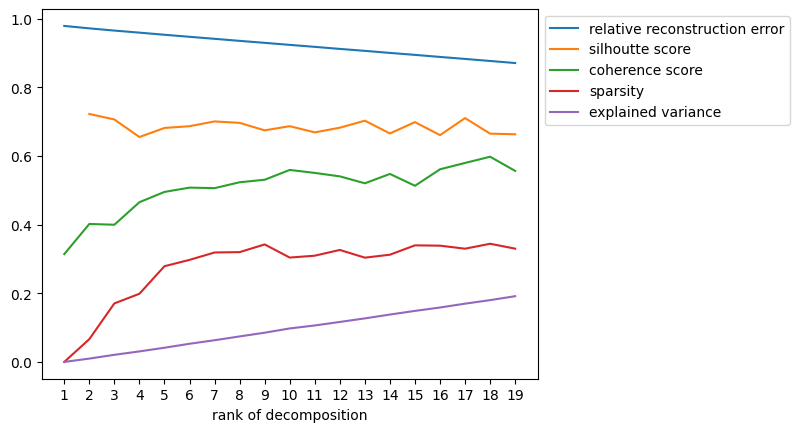

In [27]:
plt.plot(ranks, reconstruction_errors, label="relative reconstruction error")
plt.plot(ranks[1:], silhouette_scores, label="silhoutte score")
plt.plot(ranks, coherence_scores, label="coherence score")
plt.plot(ranks, sparsities, label="sparsity")
plt.plot(ranks, explained_variances, label="explained variance")

plt.xlabel("rank of decomposition")
plt.xticks(ranks)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

From the above plot we would conclude that the rank should be in the range from 5 to 8.

Combined with the knowledge that there are 6 murderers, we think that 6 is also a good value for the rank of the NMF.

In [21]:
num_narratives = 6

In [22]:
# use NMF to decompose the document vectors into topic vectors
nmf = NMF(
    n_components=num_narratives,
    max_iter=1000,
    random_state=RANDOM_STATE
)
W = nmf.fit_transform(A) # weights: document x topic
H = nmf.components_ # hidden variables: topic x words

In [23]:
narratives = [[page for page in range(len(data)) if np.argmax(W, axis=1)[page] == j] for j in range(num_narratives)]
for i, pages in enumerate(narratives):
    print(f"Narrative {i+1}:", *pages)

Narrative 1: 19 27 32 39 46 64 65 75 77 80 92
Narrative 2: 2 7 9 18 21 38 45 47 56 63 69 78 87
Narrative 3: 11 23 26 28 29 35 37 52 53 55 58 68 70 73 74 88 89 98
Narrative 4: 1 3 10 13 20 24 25 30 31 34 41 48 57 62 71 76 79 81 84 86 93 96 99
Narrative 5: 4 5 12 15 16 17 22 33 40 42 43 44 51 54 60 61 67 72 82 83 91 97
Narrative 6: 0 6 8 14 36 49 50 59 66 85 90 94 95


The number of possible arrangements of these 100 pages is $100! \approx 10^{158}$. By extracting the different narratives we have reduced this number to:

In [25]:
permutations = np.math.factorial(num_narratives) * np.sum(list(map(np.math.factorial, map(len, narratives))))
print(f"number of permutations: {permutations:.2e}")

number of permutations: 1.94e+25


Which is an improvement of 133 orders of magnitude!

So now we are left with the easy part of reading through these narratives and extracting the victims and murderers.

Our Github repository: [https://github.com/maxstolly/Data-Science-Seminar](https://github.com/maxstolly/Data-Science-Seminar)

Used resources:
- [NMF — A visual explainer and Python Implementation - Garla (2021)](https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8)
- [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation - Grisel et al](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)
- [Exploring the Space of Topic Coherence Measures - Röder et al (2015)](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
- [How to compare LDA models - Radim Řehůřek](https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html)
- [ChatGPT: Optimizing Language Models for Dialogue](https://openai.com/blog/chatgpt/)
